<a href="https://colab.research.google.com/github/nishapriya2485/Credit-Risk-Analysis-using-ml/blob/main/CREDIT_RISK_ANALYSIS_USING_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Analysis Using Machine Learning

# Problem Statement

Approving loans without proper scientific evaluation increases the risk of default. This can lead to bankruptcy of lending agencies and consequently the destabilization of the banking system. This is what happened in the 2008 financial crisis which affected the world economy adversely. Three components decide the amount of loss that a firm faces as a result of loan default:

* Probability of Default (PD)
* Exposure at Default (EAD)
* Loss given Default (LGD)
The expected loss (E-Loss) is the simple product of these three quantities:

ELoss=PD⋅EAD⋅LGD

Our focus here is on the Probability of Default (PD). Here, we will look at the example of German Credit data which is taken from the Kaggle database.

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
import plotly.figure_factory as ff
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


file_path = '/content/drive/MyDrive/credit_risk_analysis/german_credit_data.csv'


df = pd.read_csv(file_path)


df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
df_sm = df.copy()

In [ ]:
#cross table for the 'Sex' feature
cross_sex = pd.crosstab(df['Risk'], df['Sex']).apply(lambda x: x/x.sum() * 100)
decimals = pd.Series([2,2], index=['Male', 'Female'])
cross_sex = cross_sex.round(decimals)
cross_sex_transposed = cross_sex.T
cross_sex_transposed.style.background_gradient(cmap='Blues')

Risk,bad,good
Sex,,
female,35.161290,64.838710
male,27.681159,72.318841


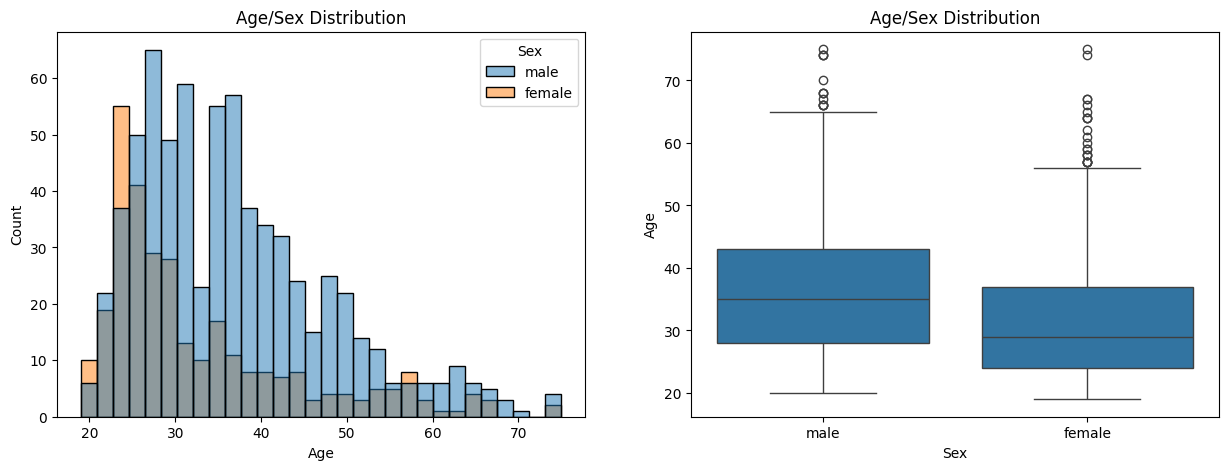

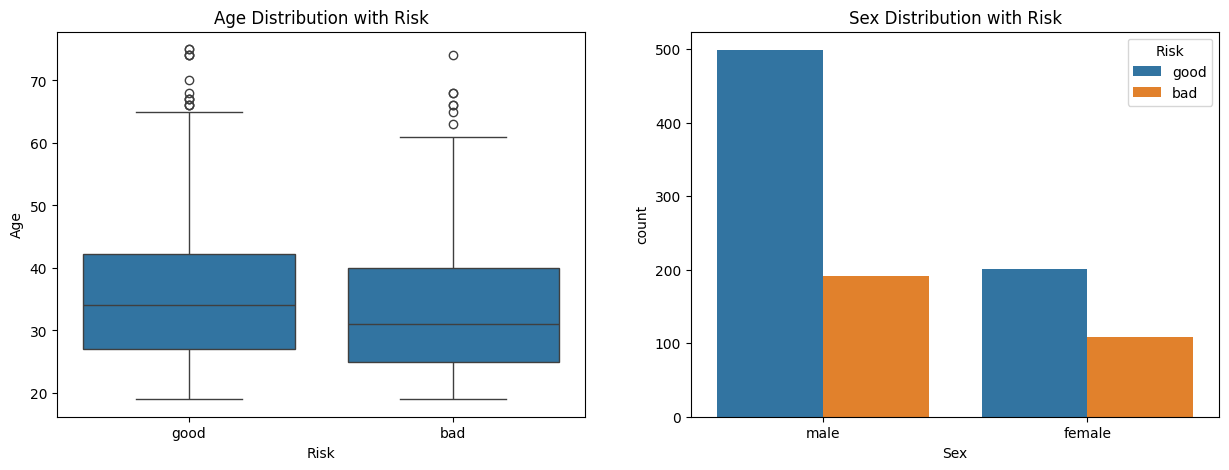

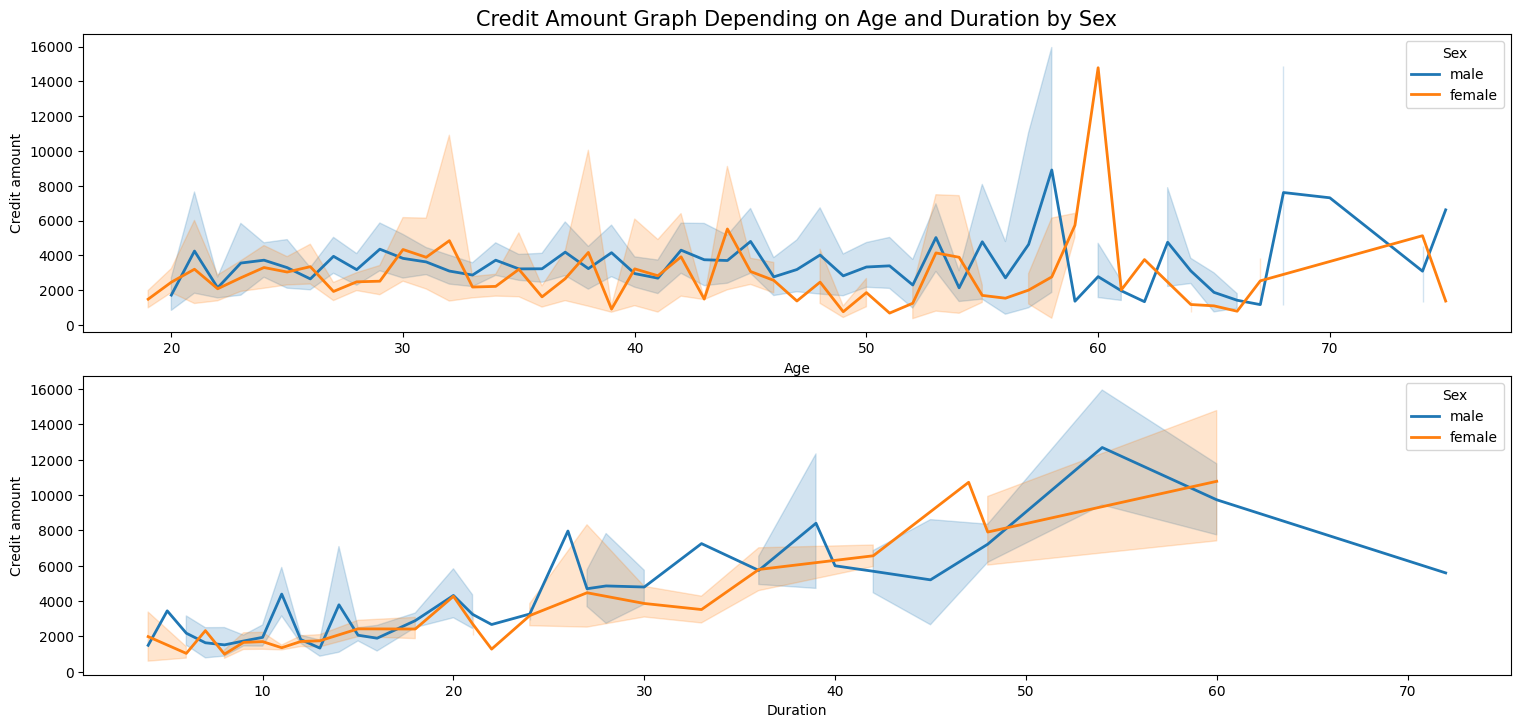

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Sex", ax=ax[0]).set_title("Age/Sex Distribution");
sns.boxplot(data=df, x="Sex", y="Age", ax=ax[1]).set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=df, x="Sex", hue="Risk", ax=ax[1]).set_title("Sex Distribution with Risk");

fig, ax = plt.subplots(2,1,figsize=(15,7))
plt.tight_layout()
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);

In [ ]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit",
    marker=dict(
        color='#85ead9'
    )
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit",
    marker=dict(
        color='#6f2cea'
    )
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker=dict(
        color='#f392f4'
    )
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/usr/local/lib/python3.11/dist-packages/plotly/tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_sm["Age_cat"] = pd.cut(df_sm.Age, interval, labels=cats)


df_good = df_sm[df_sm["Risk"] == 'good']
df_bad = df_sm[df_sm["Risk"] == 'bad']

In [ ]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#50f466'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#b2014e'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [ ]:
#First plot
trace0 = go.Bar(
                x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
                y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='#a4e23f'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
                y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='#b2014e'
                    )
                )

data = [trace0, trace1]

layout = go.Layout(title='Housing Distribuition')


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Housing-Grouped')
plt.show()


In [ ]:
#First plot
trace0 = go.Bar(
                x = df_sm[df_sm["Risk"]== 'good']["Job"].value_counts().index.values,
                y = df_sm[df_sm["Risk"]== 'good']["Job"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='#a4e23f'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df_sm[df_sm["Risk"]== 'bad']["Job"].value_counts().index.values,
                y = df_sm[df_sm["Risk"]== 'bad']["Job"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='#b2014e'
                    )
                )

data = [trace0, trace1]

layout = go.Layout(title='Job Distribuitio')


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Job-Grouped')
plt.show()


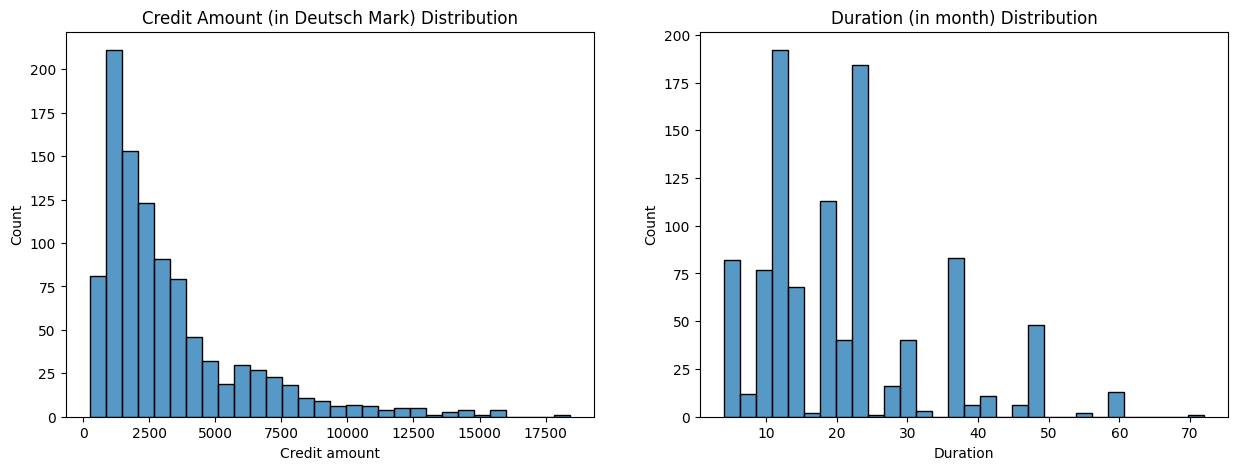

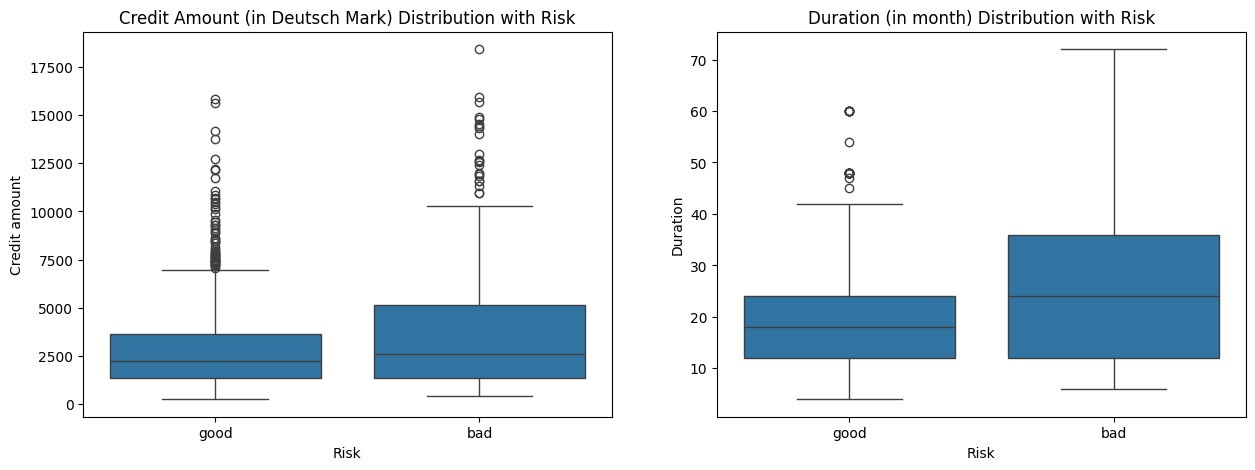

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_sm, x='Credit amount', bins=30, ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution");
sns.histplot(df_sm, x='Duration', bins=30, ax=ax[1]).set_title("Duration (in month) Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_sm, x='Risk', y='Credit amount', ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution with Risk");
sns.boxplot(data=df_sm, x='Risk', y='Duration', ax=ax[1]).set_title("Duration (in month) Distribution with Risk");

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0


In [ ]:
display(Markdown("#### Explore the Values of Text Columns:"))
cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for col in cols:
    line = "**" + col + ":** "
    for v in df[col].unique():
        line = line + str(v) + ", "
    display(Markdown(line))

#### Explore the Values of Text Columns:

**Sex:** male, female, 

**Housing:** own, free, rent, 

**Saving accounts:** nan, little, quite rich, rich, moderate, 

**Checking account:** little, moderate, nan, rich, 

**Purpose:** radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others, 

**Risk:** good, bad, 

In [ ]:
# label encode account quality and fill NaN with 0
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

df["Saving accounts"] = df["Saving accounts"].apply(SC_LabelEncoder)
df["Checking account"] = df["Checking account"].apply(SC_LabelEncoder)

In [ ]:
# label encode account quality and fill NaN with 0
def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2

df["Housing"] = df["Housing"].apply(H_LabelEncoder)

In [ ]:
# use LabelEncoder() to encode other categorical columns:
from sklearn.preprocessing import LabelEncoder
for col in ["Sex", "Purpose", "Risk", "Age"]:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,48,1,2,2,0,1,1169,6,5,1
1,1,3,0,2,2,1,2,5951,48,5,0
2,2,30,1,1,2,1,0,2096,12,3,1
3,3,26,1,2,0,1,1,7882,42,4,1
4,4,34,1,2,0,1,1,4870,24,1,0


# Build Model

### Clustering

#### Start with applying Elbow Method.

In [ ]:
cdf = df.drop("Risk", axis=1)

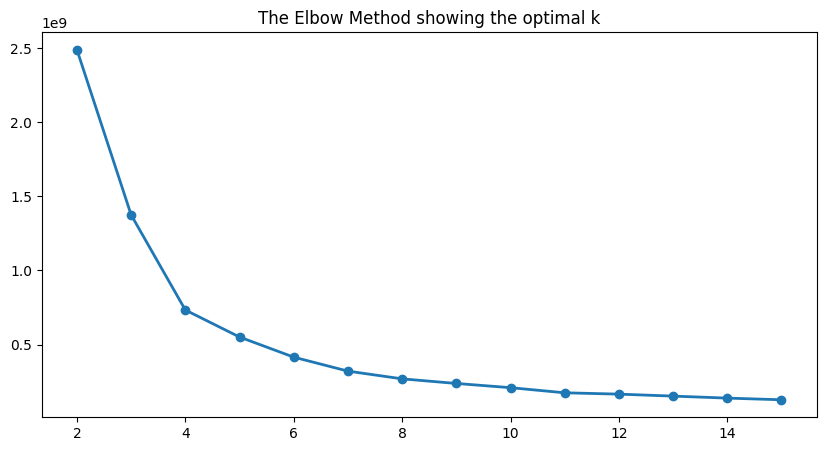

In [ ]:

inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(cdf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('The Elbow Method showing the optimal k')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2);

**Analysis:** The "elbow" in above chart is indicated  at 4. The number of clusters chosen should therefore be 4.
#### With 4 Clusters:

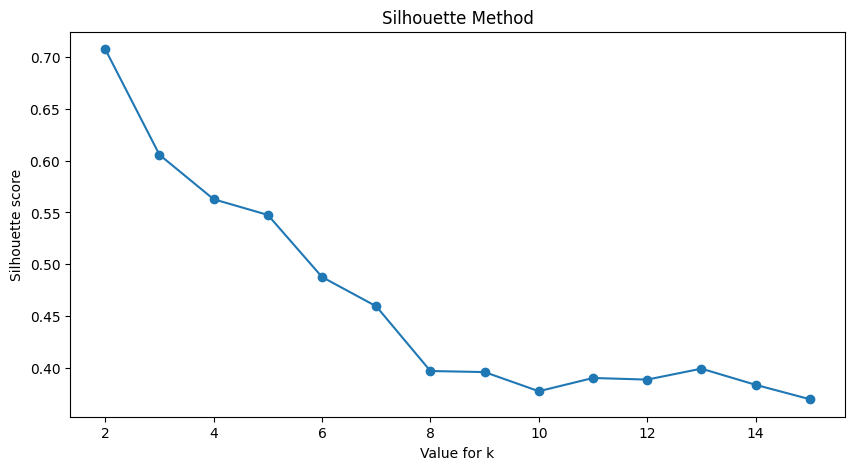

In [ ]:
k = range(2,16)
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(cdf)
    score.append(silhouette_score(cdf,kmeans.labels_))
plt.figure(figsize=(10,5))
plt.plot(k, score, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.title('Silhouette Method')
plt.show()

Use K-means to cluster people in the records into 4 group and check if the result closed to given two risk groups

In [ ]:
km = KMeans(n_clusters=4, random_state=0)
clusters = km.fit_predict(cdf)

In [ ]:
acc = max((sum(clusters == df["Risk"]) / len(df)), (sum(clusters != df["Risk"]) / len(df)))
display(Markdown("The accuracy rate of 4-Means clustering is " + str(acc)))

The accuracy rate of 4-Means clustering is 0.77

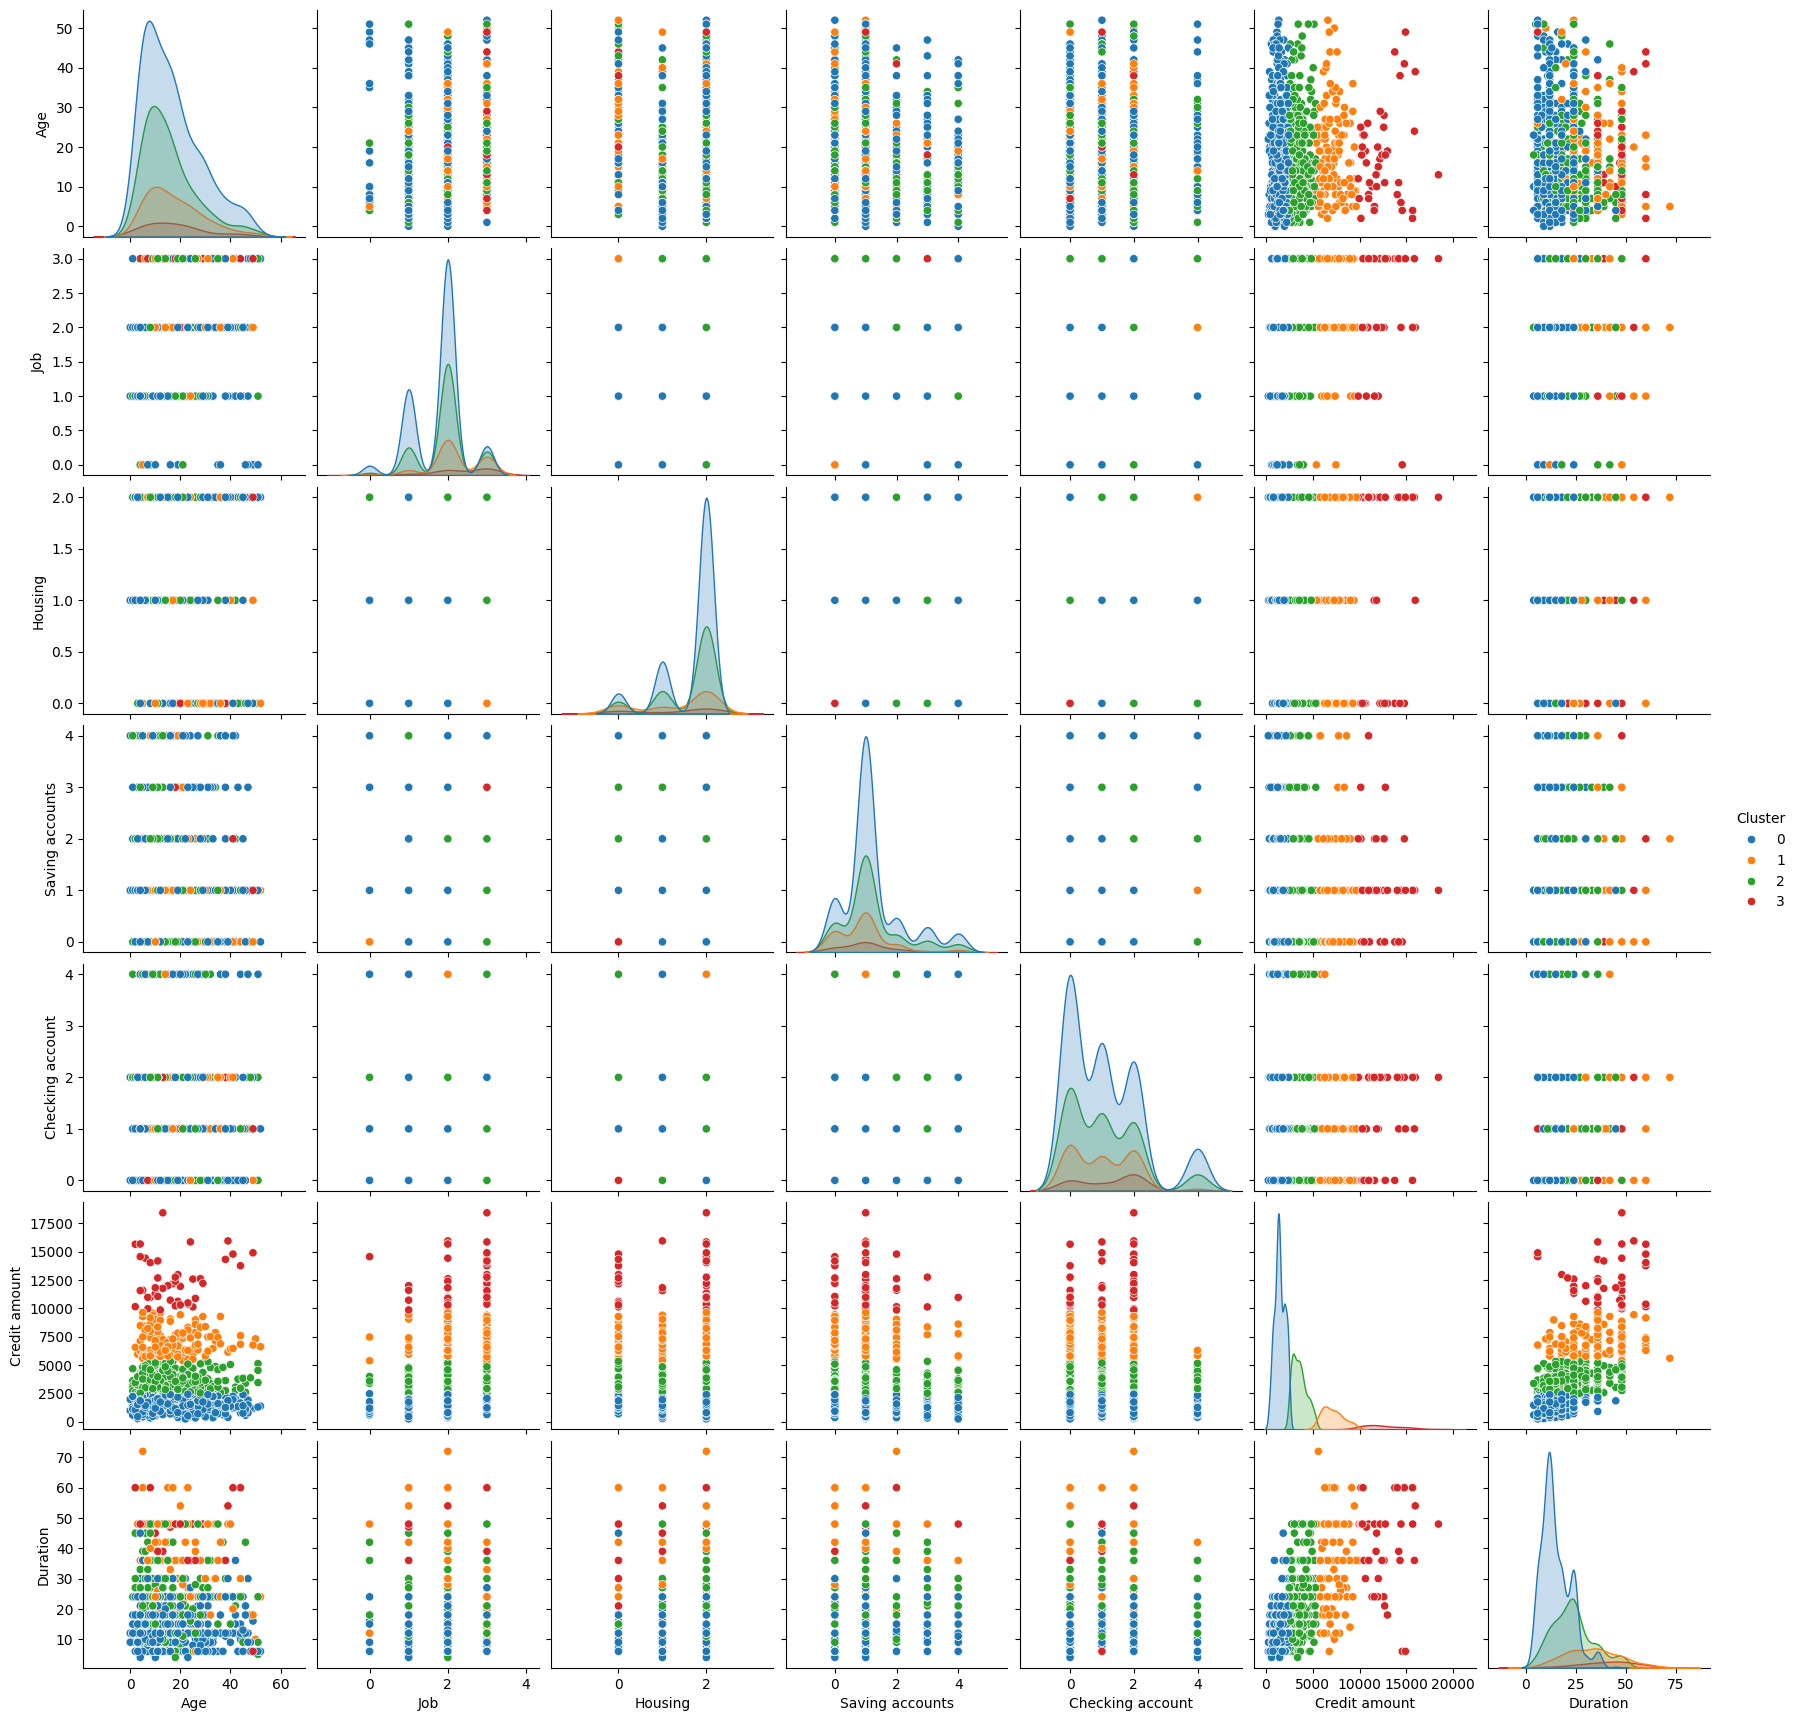

In [ ]:
df_clustered = cdf[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']]
df_clustered["Cluster"] = clusters
sns.pairplot(df_clustered, hue="Cluster",palette='tab10')

### K-Nearest Neighbors Classification

In [ ]:
# Spliting X and y into train and test version
X, y = df.drop("Risk", axis=1), df["Risk"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

In [ ]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test))
    if score > max_score:
        max_k = k
        max_score = score

display(Markdown("If use K-Nearest Neighbors Classification, the k should be " + str(max_k) + " to get best prediction, and then the  mean accuracy is " + str(max_score)))

If use K-Nearest Neighbors Classification, the k should be 69 to get best prediction, and then the  mean accuracy is 0.8352941176470589

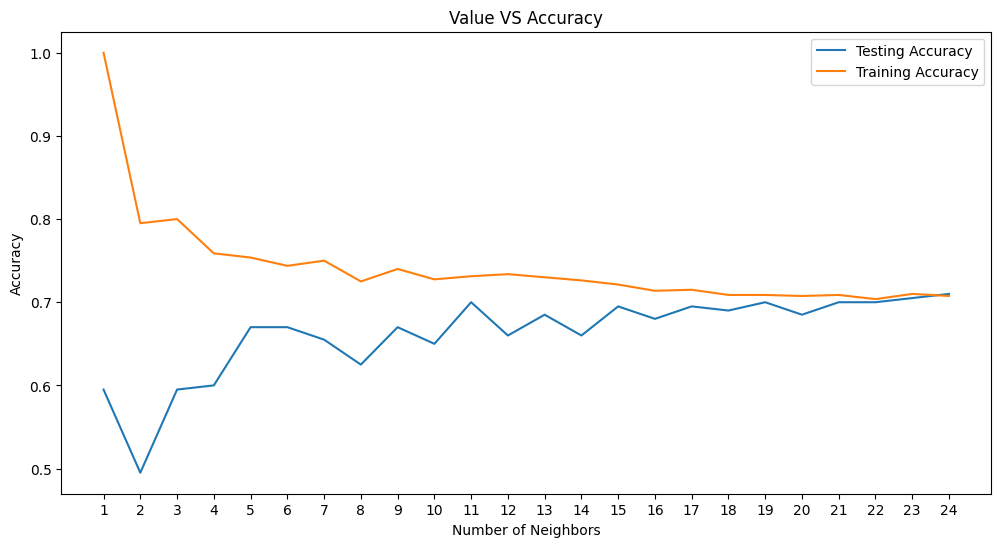

Best accuracy is 0.71 with K = 24


In [ ]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn_model.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(knn_model.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(knn_model.score(X_test, y_test))

# Plot
plt.figure(figsize=[12,6])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('Value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

In [ ]:
# define models
Models = {
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianNaiveBayes": GaussianNB(),

}

In [ ]:
from sklearn import model_selection
import pandas as pd

cv_results = []  # Use a list to collect results first

for key in Models.keys():
    cv_res = model_selection.cross_validate(
        Models[key], X_train, y_train,
        return_train_score=True,
        scoring="f1",
        cv=5, n_jobs=-1
    )
    res = {
        'model': key,
        'train_score': cv_res["train_score"].mean(),
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean()
    }
    cv_results.append(res)  # Append dict to list
    print("CV for model:", key, "done.")

# Convert list of dicts to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Display with color gradient
cv_results_df.style.background_gradient(cmap='Blues')


CV for model: SVC done.
CV for model: DecisionTree done.
CV for model: RandomForest done.
CV for model: GaussianNaiveBayes done.


,model,train_score,test_score,fit_time,score_time
0,SVC,0.825890,0.826072,0.083997,0.029310
1,DecisionTree,1.000000,0.751083,0.017346,0.013232
2,RandomForest,1.000000,0.830181,0.561286,0.043395
3,GaussianNaiveBayes,0.811976,0.810961,0.018984,0.020067


In [ ]:
rf = Models["RandomForest"].fit(X_train, y_train)
print('f1_score:', f1_score(y_test, rf.predict(X_test)))

f1_score: 0.8271186440677966


In [ ]:
from sklearn.svm import SVC
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
feature_importance["importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

,feature,importance
7,Credit amount,0.203533
0,Unnamed: 0,0.168023
1,Age,0.145017
8,Duration,0.134850
6,Checking account,0.120339
9,Purpose,0.074393
5,Saving accounts,0.054358
3,Job,0.043307
4,Housing,0.031552
2,Sex,0.024628
